<a href="https://colab.research.google.com/github/Fadhilstat/Fadhilstat-s-Personal-Projects/blob/main/Project_Linear_Regression_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project – Simple Linear Regression (Appliances Used → Energy Consumption)

**Goal:** Memodelkan hubungan linear antara banyaknya *appliances used* (X) dan *energy consumption* (Y) menggunakan **OLS**, mengevaluasi performa (R², RMSE, MAE), memeriksa asumsi (residual diagnostics), serta membuat prediksi dengan **confidence interval (CI)** dan **prediction interval (PI)**.

**Referensi kuliah ringkas:**  
- SLR model & OLS (β̂): file *Regresi Linier Sederhana – Bagian I*  
- Asumsi LINE (normalitas, homoskedastisitas, independensi): *Bagian II*  
- Estimator σ², uji t/F, GoF: *Bagian III*  
- Korelasi r, R², CI/PI: *Bagian IV*


In [1]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "test_energy_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "govindaramsriram/energy-consumption-dataset-linear-regression",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# matplotlib inline (for Jupyter)
%matplotlib inline

# Keep only the required columns
expected_cols = ["Appliances Used", "Energy Consumption"]
missing = [c for c in expected_cols if c not in df.columns]
df = df[["Appliances Used","Energy Consumption"].copy()]

print("Dataset loaded. Shape:", df.shape)
df.head()


/tmp/ipython-input-1611331790.py:16: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'energy-consumption-dataset-linear-regression' dataset.
Dataset loaded. Shape: (100, 2)


,Appliances Used,Energy Consumption
0,4,2865.57
1,23,4283.80
2,44,5067.83
3,17,4624.30
4,47,4820.59


## Data Preparation

In [2]:
# Cek kebersihan data
print("Missing values per kolom:\n", df.isna().sum())
print("\nDuplikat baris:", df.duplicated().sum())

# Drop duplicates (konservatif)
df_clean = df.drop_duplicates().copy()
print("\nShape setelah bersih:", df_clean.shape)

# Train-test split (80/20)
train, test = train_test_split(df_clean, test_size=0.2, random_state=23)

print("\nTrain shape:", train.shape, " | Test shape:", test.shape)
train.head()


Missing values per kolom:
 Appliances Used       0
Energy Consumption    0
dtype: int64

Duplikat baris: 0

Shape setelah bersih: (100, 2)

Train shape: (80, 2)  | Test shape: (20, 2)


,Appliances Used,Energy Consumption
85,17,4652.65
28,24,3999.14
8,16,3969.09
11,41,3810.09
63,49,2725.89


## Exploratory Visualization & Correlation

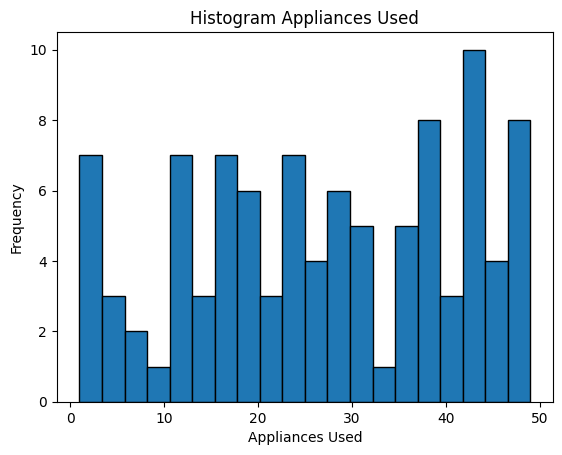

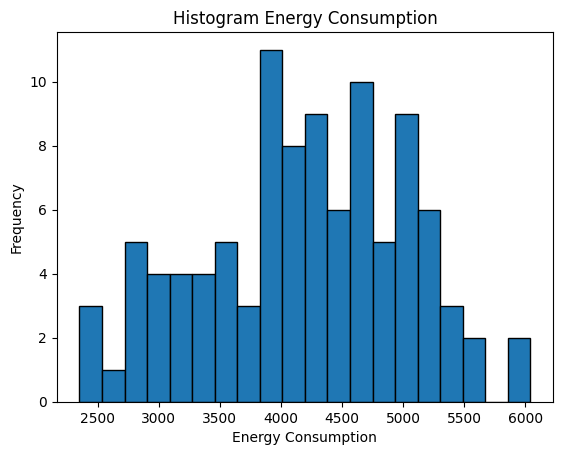

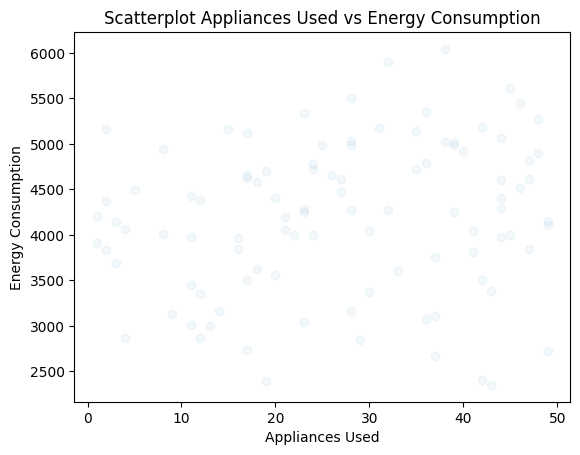

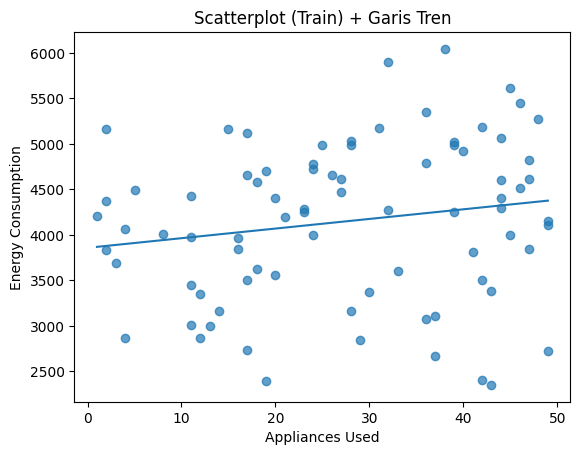

Korelasi Pearson (train): r = 0.176


In [3]:
# Visualiasi
plt.hist(df_clean['Appliances Used'],bins = 20, edgecolor = 'black')
plt.xlabel('Appliances Used')
plt.ylabel('Frequency')
plt.title('Histogram Appliances Used')
plt.show()

plt.hist(df_clean['Energy Consumption'],bins = 20, edgecolor = 'black')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')
plt.title('Histogram Energy Consumption')
plt.show()

plt.scatter(df_clean['Appliances Used'],df_clean['Energy Consumption'], alpha = 0.05)
plt.xlabel('Appliances Used')
plt.ylabel('Energy Consumption')
plt.title('Scatterplot Appliances Used vs Energy Consumption')
plt.show()

# Scatter + estimasi garis regresi sederhana (manual via numpy polyfit untuk visual)
plt.figure()
plt.scatter(train["Appliances Used"], train["Energy Consumption"], alpha=0.7)
# garis fit kasar agar plot informatif (visual), bukan estimasi resmi (akan dipakai OLS di bawah)
m, b = np.polyfit(train["Appliances Used"], train["Energy Consumption"], 1)
x_line = np.linspace(train["Appliances Used"].min(), train["Appliances Used"].max(), 100)
plt.plot(x_line, m*x_line + b)
plt.xlabel("Appliances Used")
plt.ylabel("Energy Consumption")
plt.title("Scatterplot (Train) + Garis Tren")
plt.show()

# Korelasi Pearson
r = train["Appliances Used"].corr(train["Energy Consumption"])
print(f"Korelasi Pearson (train): r = {r:.3f}")


## Modeling (OLS – statsmodels)

In [4]:
# Siapkan desain matrix (dengan konstanta)
X_train = sm.add_constant(train["Appliances Used"])
y_train = train["Energy Consumption"]

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Simpan koefisien
b0 = model.params["const"]
b1 = model.params["Appliances Used"]
print(f"Intercept (b0) = {b0:.4f}, Slope (b1) = {b1:.4f}")
print("Interpretasi: setiap +1 unit Appliances Used → rata-rata Energy naik ~", f"{b1:.2f}")


                            OLS Regression Results                            
Dep. Variable:     Energy Consumption   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.486
Date:                Wed, 01 Oct 2025   Prob (F-statistic):              0.119
Time:                        15:23:14   Log-Likelihood:                -652.98
No. Observations:                  80   AIC:                             1310.
Df Residuals:                      78   BIC:                             1315.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3857.8905    207.503     

## Evaluation (Train vs Test)

In [5]:
# === Train ===
yhat_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
mae_train = mean_absolute_error(y_train, yhat_train)
r2_train = r2_score(y_train, yhat_train)

# === Test ===
X_test = sm.add_constant(test["Appliances Used"])
y_test = test["Energy Consumption"]
yhat_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
mae_test = mean_absolute_error(y_test, yhat_test)
r2_test = r2_score(y_test, yhat_test)

# Adjusted R^2 (test) – p = 1 predictor
n_test = len(y_test)
p = 1
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1) if n_test > p + 1 else np.nan

print("=== Train ===")
print(f"R^2: {r2_train:.3f} | RMSE: {rmse_train:.3f} | MAE: {mae_train:.3f}")
print("\n=== Test ===")
print(f"R^2: {r2_test:.3f} | Adj. R^2: {adj_r2_test:.3f}")
print(f"RMSE: {rmse_test:.3f} | MAE: {mae_test:.3f}")


=== Train ===
R^2: 0.031 | RMSE: 848.405 | MAE: 695.960

=== Test ===
R^2: -0.062 | Adj. R^2: -0.121
RMSE: 674.665 | MAE: 544.075


## Residual Diagnostics

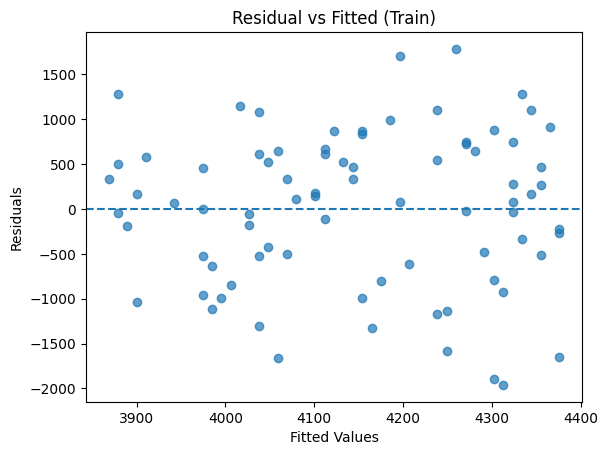

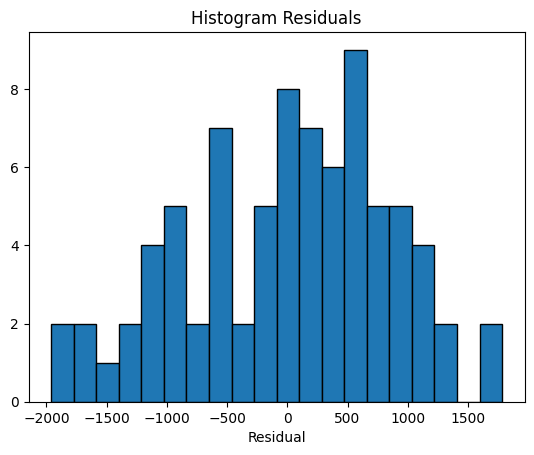

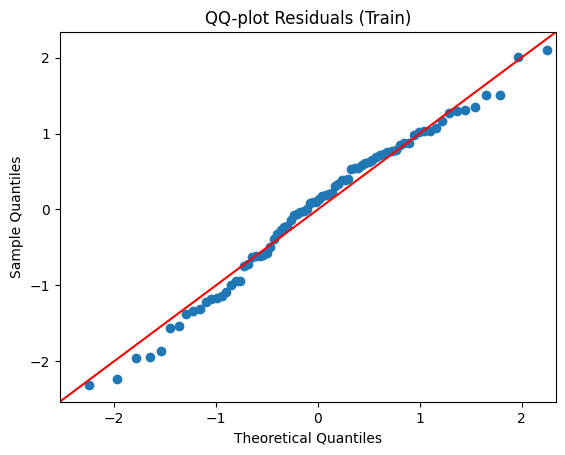

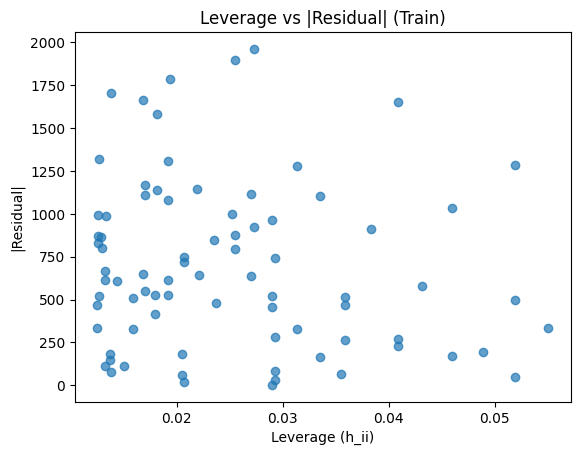

Durbin–Watson: 2.2
Cook's distance (top 5):
Index 4 -> Cook's D = 0.0819, leverage = 0.0409, resid = -1650.1796
Index 13 -> Cook's D = 0.0751, leverage = 0.0273, resid = -1960.6491
Index 33 -> Cook's D = 0.0653, leverage = 0.0254, resid = -1896.7040
Index 17 -> Cook's D = 0.0643, leverage = 0.0519, resid = 1282.8994
Index 37 -> Cook's D = 0.0432, leverage = 0.0193, resid = 1782.8164


In [6]:
resid = model.resid
fitted = model.fittedvalues

# Residual vs Fitted
plt.figure()
plt.scatter(fitted, resid, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual vs Fitted (Train)")
plt.show()

# Histogram
plt.hist(resid, bins=20, edgecolor='black')
plt.title("Histogram Residuals"); plt.xlabel("Residual"); plt.show()

# QQ Plot
fig = sm.qqplot(resid, line='45', fit=True)
plt.title("QQ-plot Residuals (Train)")
plt.show()

# Optional: Leverage & Influence
influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]

plt.figure()
plt.scatter(leverage, np.abs(resid), alpha=0.7)
plt.xlabel("Leverage (h_ii)")
plt.ylabel("|Residual|")
plt.title("Leverage vs |Residual| (Train)")
plt.show()

print("Durbin–Watson:", round(durbin_watson(resid), 3))

print("Cook's distance (top 5):")
top5_idx = np.argsort(cooks)[-5:][::-1]
for i in top5_idx:
    print(f"Index {i} -> Cook's D = {cooks[i]:.4f}, leverage = {leverage[i]:.4f}, resid = {resid.iloc[i]:.4f}")


## Prediction with Interval (CI & PI)

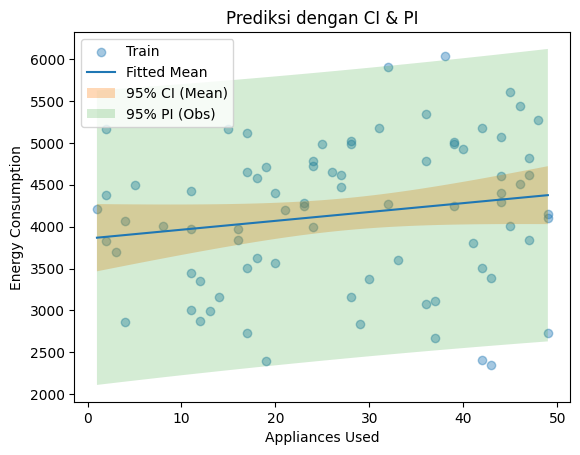

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3868.465534,201.582058,3467.146484,4269.784584,2111.456304,5625.474764
1,3878.824800,195.831342,3488.954546,4268.695053,2124.395186,5633.254413
2,3889.184066,190.133702,3510.656943,4267.711188,2137.240220,5641.127911
3,3899.543331,184.494055,3532.243884,4266.842779,2149.991006,5649.095657
4,3909.902597,178.917885,3553.704451,4266.100744,2162.647157,5657.158038


In [7]:
# Prediksi pada grid X untuk membuat pita CI/PI
x0 = np.linspace(df_clean["Appliances Used"].min(), df_clean["Appliances Used"].max(), 50)
X0 = sm.add_constant(pd.DataFrame({"Appliances Used": x0}))

pred = model.get_prediction(X0)
pred_summary = pred.summary_frame(alpha=0.05)  # 95%

# Visualisasi CI (mean) dan PI (obs)
plt.figure()
plt.scatter(train["Appliances Used"], train["Energy Consumption"], alpha=0.4, label="Train")
plt.plot(x0, pred_summary["mean"], label="Fitted Mean")
plt.fill_between(x0, pred_summary["mean_ci_lower"], pred_summary["mean_ci_upper"], alpha=0.3, label="95% CI (Mean)")
plt.fill_between(x0, pred_summary["obs_ci_lower"], pred_summary["obs_ci_upper"], alpha=0.2, label="95% PI (Obs)")
plt.xlabel("Appliances Used")
plt.ylabel("Energy Consumption")
plt.title("Prediksi dengan CI & PI")
plt.legend()
plt.show()

pred_summary.head()


## Kesimpulan & Catatan Praktis

- **Slope (β̂₁)** → interpretasi langsung: setiap kenaikan 1 unit *Appliances Used* menaikkan **rata-rata** *Energy Consumption* sebesar ~β̂₁ unit (ceteris paribus).
- **Goodness-of-fit** → bandingkan **R² (train)** dan **Adjusted R² (test)** serta **RMSE/MAE** untuk menilai *generalization*.
- **Residual diagnostics** → pola pada residual vs fitted ⇒ indikasi non-linearitas / heteroskedastisitas; QQ-plot ⇒ penyimpangan normalitas.
- **CI vs PI** → **CI** untuk *mean response*; **PI** untuk prediksi *individual* (lebih lebar).
- **Keterbatasan**: hanya satu prediktor; bias akibat variabel terlewat (omitted variable bias) mungkin ada; pertimbangkan transformasi (log/Box–Cox) bila pola non-linear.
- **Next step (opsional)**: tambah prediktor (MLR), uji multicollinearity (VIF), validasi silang (k-fold), atau coba regularisasi (ridge/lasso).
